In [1]:
import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
# from dgl import AddSelfLoop
# from dgl.data import CiteseerGraphDataset, CoraGraphDataset, PubmedGraphDataset

# for metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
class GCN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()
        self.layers = nn.ModuleList()
        # two-layer GCN
        self.layers.append(
            dglnn.GraphConv(in_size, hid_size, activation=F.relu)
        )
        self.layers.append(dglnn.GraphConv(hid_size, out_size))
        self.dropout = nn.Dropout(0.5)

    def forward(self, g, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(g, h)
        return h

In [3]:
def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1


def train(g, features, labels, masks, model, epochs=2000, patience=1500, save_path='best_model.pth'):
    train_mask = masks[0]
    val_mask = masks[1]
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    best_val_acc = 0
    patience_counter = 0

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        logits = model(g, features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Evaluate on validation set
        val_acc, val_f1 = evaluate(g, features, labels, val_mask, model)
        if epoch % 100 == 0:
            print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Val Accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}")

        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1

        if patience_counter == patience:
            print("Early stopping triggered.")
            break


def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        predictions = torch.argmax(logits[mask], dim=1)
        acc = (predictions == labels[mask]).float().mean()
        f1 = f1_score(labels[mask].cpu(), predictions.cpu(), average='weighted')
    return acc.item(), f1

## load datasets

In [126]:
from datasets import Bail
bail = Bail()
adj, features, idx_train, idx_val, idx_test, labels, sens, feat_names, sens_names \
    = bail.adj(), bail.features(), bail.idx_train(), bail.idx_val(), \
      bail.idx_test(), bail.labels(), bail.sens(), bail.feat_names(), bail.sens_names()

In [148]:
from datasets import Nba
nba = Nba()
adj, features, idx_train, idx_val, idx_test, labels, sens, feat_names, sens_names \
    = nba.adj(), nba.features(), nba.idx_train(), nba.idx_val(), \
      nba.idx_test(), nba.labels(), nba.sens(), nba.feat_names(), nba.sens_names()

In [161]:
from datasets import Pokec_n
pokec_n = Pokec_n()
adj, features, idx_train, idx_val, idx_test, labels, sens, feat_names, sens_names \
    = pokec_n.adj(), pokec_n.features(), pokec_n.idx_train(), pokec_n.idx_val(), \
      pokec_n.idx_test(), pokec_n.labels(), pokec_n.sens(), pokec_n.feat_names(), pokec_n.sens_names()

In [157]:
from datasets import Pokec_z
pokec_z = Pokec_z()
adj, features, idx_train, idx_val, idx_test, labels, sens, feat_names, sens_names \
    = pokec_z.adj(), pokec_z.features(), pokec_z.idx_train(), pokec_z.idx_val(), \
      pokec_z.idx_test(), pokec_z.labels(), pokec_z.sens(), pokec_z.feat_names(), pokec_z.sens_names()

## process dataset

In [162]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# masks = g.ndata["train_mask"], g.ndata["val_mask"], g.ndata["test_mask"]
# Get the source and destination node IDs
# adj = adj.int().to(device)
src, dst = adj.coalesce().indices()

# Create the heterograph
g = dgl.heterograph({('node', 'edge', 'node'): (src.cpu().numpy(), dst.cpu().numpy())})
g = g.int().to(device)

# convert idx_train, idx_val, idx_test to boolean masks
train_mask = torch.zeros(adj.shape[0], dtype=torch.bool)
val_mask = torch.zeros(adj.shape[0], dtype=torch.bool)
test_mask = torch.zeros(adj.shape[0], dtype=torch.bool)
train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True
masks = train_mask, val_mask, test_mask

# normalize features
features = feature_norm(features)

features = features.to(device)
labels = labels.to(device)

## train model

In [52]:
# create GCN model
in_size = features.shape[1]
out_size = int(sum(labels.unique() != -1))
model = GCN(in_size, 16, out_size).to(device)

In [53]:
# model training
print("Training...")
train(g, features, labels, masks, model, save_path='evaluation/cases/gcn/gcn_pokecz.pth')

Training...


Epochs:   0%|          | 5/2000 [00:00<00:46, 42.89it/s]

Epoch 00000 | Loss 1.1622 | Val Accuracy 0.5520 | Val F1 0.3927


Epochs:   5%|▌         | 109/2000 [00:01<00:28, 65.49it/s]

Epoch 00100 | Loss 0.6107 | Val Accuracy 0.6827 | Val F1 0.6835


Epochs:  11%|█         | 211/2000 [00:03<00:25, 69.45it/s]

Epoch 00200 | Loss 0.6035 | Val Accuracy 0.6881 | Val F1 0.6886


Epochs:  16%|█▌        | 315/2000 [00:04<00:23, 71.08it/s]

Epoch 00300 | Loss 0.5815 | Val Accuracy 0.6912 | Val F1 0.6916


Epochs:  20%|██        | 409/2000 [00:06<00:23, 68.18it/s]

Epoch 00400 | Loss 0.5892 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  25%|██▌       | 509/2000 [00:07<00:20, 73.54it/s]

Epoch 00500 | Loss 0.5755 | Val Accuracy 0.6893 | Val F1 0.6894


Epochs:  31%|███       | 613/2000 [00:09<00:19, 71.70it/s]

Epoch 00600 | Loss 0.5768 | Val Accuracy 0.6893 | Val F1 0.6894


Epochs:  35%|███▌      | 709/2000 [00:10<00:23, 54.27it/s]

Epoch 00700 | Loss 0.5707 | Val Accuracy 0.6885 | Val F1 0.6886


Epochs:  41%|████      | 813/2000 [00:12<00:18, 64.21it/s]

Epoch 00800 | Loss 0.5844 | Val Accuracy 0.6885 | Val F1 0.6886


Epochs:  45%|████▌     | 909/2000 [00:13<00:14, 73.21it/s]

Epoch 00900 | Loss 0.5771 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  51%|█████     | 1012/2000 [00:15<00:14, 67.83it/s]

Epoch 01000 | Loss 0.5802 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  56%|█████▌    | 1116/2000 [00:16<00:11, 75.50it/s]

Epoch 01100 | Loss 0.5738 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  61%|██████    | 1212/2000 [00:17<00:10, 74.56it/s]

Epoch 01200 | Loss 0.5782 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  65%|██████▌   | 1308/2000 [00:19<00:10, 68.98it/s]

Epoch 01300 | Loss 0.5759 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  71%|███████   | 1413/2000 [00:20<00:08, 72.31it/s]

Epoch 01400 | Loss 0.5694 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  75%|███████▌  | 1508/2000 [00:21<00:06, 72.71it/s]

Epoch 01500 | Loss 0.5794 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  81%|████████  | 1611/2000 [00:23<00:06, 64.07it/s]

Epoch 01600 | Loss 0.5757 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  86%|████████▌ | 1713/2000 [00:24<00:04, 71.62it/s]

Epoch 01700 | Loss 0.5861 | Val Accuracy 0.6889 | Val F1 0.6890


Epochs:  90%|████████▉ | 1792/2000 [00:26<00:03, 68.70it/s]

Early stopping triggered.


## load model

In [23]:
# create GCN model
in_size = features.shape[1]
out_size = int(sum(labels.unique() != -1))
model = GCN(in_size, 16, out_size).to(device)

In [24]:
# load the model
model.load_state_dict(torch.load('evaluation/cases/gcn/gcn_pokecz.pth'))

<All keys matched successfully>

In [25]:
model.eval()
with torch.no_grad():
    logits = model(g, features)

## metrics

In [35]:
def micro_f1_std_dev(prediction, labels, groups):
    unique_groups = np.unique(groups)
    micro_f1_scores = []

    for group in unique_groups:
        group_indices = np.where(groups == group)
        group_pred = prediction[group_indices]
        group_labels = labels[group_indices]

        micro_f1 = f1_score(group_labels, group_pred, average='micro')
        micro_f1_scores.append(micro_f1)

    std_dev = np.std(micro_f1_scores)
    return std_dev

# Example usage:
std_dev = micro_f1_std_dev(prediction, labels, groups)

In [37]:
def surrogate_di(prediction, labels, groups):
    unique_groups = np.unique(groups)
    unique_labels = np.unique(labels)
    
    std_devs = []

    for label in unique_labels:
        positive_proportions = []

        for group in unique_groups:
            group_indices = np.where(groups == group)
            group_predictions = prediction[group_indices]

            # Proportion of positive predictions for the current group and label
            positive_proportion = np.mean(group_predictions == label)
            positive_proportions.append(positive_proportion)

        # Standard deviation of proportions for the current label
        std_dev = np.std(positive_proportions)
        std_devs.append(std_dev)

    # Mean of standard deviations across all labels
    mean_std_dev = np.mean(std_devs)
    return mean_std_dev

# Example usage:
metric_value = surrogate_di(prediction, labels, groups)

In [40]:
def efpr(prediction, labels, groups):
    unique_groups = np.unique(groups)
    unique_labels = np.unique(labels)
    
    efpr_std_devs = []

    for label in unique_labels:
        fpr_values = []
        
        for group in unique_groups:
            # Define true negatives and false positives for the group and label
            tn = np.sum((prediction[groups == group] != label) & (labels[groups == group] != label))
            fp = np.sum((prediction[groups == group] == label) & (labels[groups == group] != label))
            
            # Calculate FPR for the group
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fpr_values.append(fpr)

        # Compute the standard deviation of FPR for the current label
        std_dev = np.std(fpr_values)
        efpr_std_devs.append(std_dev)

    # Calculate the mean of the standard deviations across all labels
    mean_efpr_std_dev = np.mean(efpr_std_devs)
    return mean_efpr_std_dev

def efnr(prediction, labels, groups):
    unique_groups = np.unique(groups)
    unique_labels = np.unique(labels)
    
    efnr_std_devs = []

    for label in unique_labels:
        fnr_values = []
        
        for group in unique_groups:
            # Define false negatives and true positives for the group and label
            fn = np.sum((prediction[groups == group] != label) & (labels[groups == group] == label))
            tp = np.sum((prediction[groups == group] == label) & (labels[groups == group] == label))
            
            # Calculate FNR for the group
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            fnr_values.append(fnr)

        # Compute the standard deviation of FNR for the current label
        std_dev = np.std(fnr_values)
        efnr_std_devs.append(std_dev)

    # Calculate the mean of the standard deviations across all labels
    mean_efnr_std_dev = np.mean(efnr_std_devs)
    return mean_efnr_std_dev

# Example usage:
mean_efpr = efpr(prediction, labels, groups)
mean_efnr = efnr(prediction, labels, groups)

In [41]:
def etpr(prediction, labels, groups):
    unique_groups = np.unique(groups)
    unique_labels = np.unique(labels)
    
    etpr_std_devs = []

    for label in unique_labels:
        tpr_values = []
        
        for group in unique_groups:
            # Define true positives and false negatives for the group and label
            tp = np.sum((prediction[groups == group] == label) & (labels[groups == group] == label))
            fn = np.sum((prediction[groups == group] != label) & (labels[groups == group] == label))
            
            # Calculate TPR for the group
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            tpr_values.append(tpr)

        # Compute the standard deviation of TPR for the current label
        std_dev = np.std(tpr_values)
        etpr_std_devs.append(std_dev)

    # Calculate the mean of the standard deviations across all labels
    mean_etpr_std_dev = np.mean(etpr_std_devs)
    return mean_etpr_std_dev

mean_etpr = etpr(prediction, labels, groups)

In [42]:
def delta_dp_metric(predictions, labels, groups):
    unique_labels = np.unique(labels)
    unique_groups = np.unique(groups)
    
    label_group_probs = []

    # Compute the probability P(Y_hat = y | S = s) for each label and group
    for label in unique_labels:
        group_probs = []
        for group in unique_groups:
            # Calculate the number of occurrences where the prediction is equal to the current label within the current group
            group_predictions = predictions[groups == group]
            prob = np.mean(group_predictions == label)
            group_probs.append(prob)
        
        # Calculate the standard deviation of the probabilities for the current label across groups
        std_dev = np.std(group_probs)
        label_group_probs.append(std_dev)
    
    # Calculate the mean of the standard deviations across all labels
    delta_dp = np.mean(label_group_probs)
    return delta_dp

# Example usage:
metric_value = delta_dp_metric(prediction, labels, groups)

In [43]:
def max_diff_delta_dp(predictions, labels, groups):
    unique_labels = np.unique(labels)
    unique_groups = np.unique(groups)
    
    max_diffs = []

    # Compute the maximum difference in probabilities P(Y_hat = y | S = s) for each label
    for label in unique_labels:
        group_probs = []

        # Calculate the probabilities for the current label within each group
        for group in unique_groups:
            group_predictions = predictions[groups == group]
            prob = np.mean(group_predictions == label)
            group_probs.append(prob)
        
        # Calculate the maximum difference in probabilities for the current label across all group pairs
        max_diff = max([abs(p1 - p2) for p1 in group_probs for p2 in group_probs if p1 != p2])
        max_diffs.append(max_diff)
    
    # Calculate the mean of the maximum differences across all labels
    delta_max_diff = np.mean(max_diffs)
    return delta_max_diff

# Example usage:
metric_value = max_diff_delta_dp(prediction, labels, groups)

In [45]:
def delta_eo_metric(predictions, labels, groups):
    unique_labels = np.unique(labels)
    unique_groups = np.unique(groups)
    
    eo_std_devs = []

    for label in unique_labels:
        conditional_probs = []
        
        for group in unique_groups:
            # Indices where the true label is the current label for the current group
            true_label_indices = (labels == label) & (groups == group)
            true_label_group_count = np.sum(true_label_indices)
            
            # Avoid division by zero
            if true_label_group_count == 0:
                continue

            # Calculate the conditional probability P(Y_hat=y | Y=y, S=s) for the current group
            correct_pred_for_group = np.sum((predictions[true_label_indices] == label))
            conditional_prob = correct_pred_for_group / true_label_group_count
            conditional_probs.append(conditional_prob)

        # Calculate the standard deviation of the conditional probabilities for the current label
        std_dev = np.std(conditional_probs) if len(conditional_probs) > 1 else 0
        eo_std_devs.append(std_dev)

    # Calculate the mean of the standard deviations across all labels
    mean_eo_std_dev = np.mean(eo_std_devs)
    return mean_eo_std_dev

# Example usage:
metric_value = delta_eo_metric(prediction, labels, groups)

In [48]:
def delta_accuracy_metric(predictions, labels, groups):
    unique_groups = np.unique(groups)
    accuracies = []

    for group in unique_groups:
        # Select the predictions and labels for the current group
        group_indices = np.where(groups == group)
        group_predictions = predictions[group_indices]
        group_labels = labels[group_indices]

        # Calculate the accuracy for the current group
        group_accuracy = accuracy_score(group_labels, group_predictions)
        accuracies.append(group_accuracy)

    # Calculate the difference between the maximum and minimum accuracies
    delta_acc = max(accuracies) - min(accuracies)
    return delta_acc

# Example usage:
metric_value = delta_accuracy_metric(prediction, labels, groups)

In [49]:
def sigma_accuracy_metric(predictions, labels, groups):
    unique_groups = np.unique(groups)
    accuracies = []

    for group in unique_groups:
        # Select the predictions and labels for the current group
        group_indices = np.where(groups == group)
        group_predictions = predictions[group_indices]
        group_labels = labels[group_indices]

        # Calculate the accuracy for the current group
        group_accuracy = accuracy_score(group_labels, group_predictions)
        accuracies.append(group_accuracy)

    # Compute the mean accuracy
    mean_accuracy = np.mean(accuracies)
    
    # Compute the standard deviation of accuracies
    sigma_acc = np.sqrt(np.mean((accuracies - mean_accuracy) ** 2))
    return sigma_acc

# Example usage:
metric_value = sigma_accuracy_metric(prediction, labels, groups)

In [53]:
def delta_ted_metric(predictions, labels, groups):
    unique_labels = np.unique(labels)
    unique_groups = np.unique(groups)
    
    ted_stds = []

    for label in unique_labels:
        # List to store the ratio of false positives to false negatives for each group
        ratios = []
        
        for group in unique_groups:
            # Define false positives and false negatives for the current group
            fp = np.sum((predictions == label) & (labels != label) & (groups == group))
            fn = np.sum((predictions != label) & (labels == label) & (groups == group))
            
            # Avoid division by zero
            if fn == 0:
                ratio = float('inf')  # Could also choose to skip this group or set a high value
            else:
                ratio = fp / fn
            
            ratios.append(ratio)
        
        # Compute the standard deviation of these ratios for the current label
        std_dev = np.std(ratios) if len(ratios) > 1 else 0
        ted_stds.append(std_dev)
    
    # Calculate the mean of the standard deviations across all labels
    delta_ted_mean = np.mean(ted_stds) if ted_stds else 0
    return delta_ted_mean

# Example usage:
metric_value = delta_ted_metric(prediction, labels, groups)

## PDD

In [17]:
from pyeug.metrics.approximator import grad_z_graph, cal_influence_graph, s_test_graph_cost, cal_influence_graph_nodal

import numpy as np
import scipy.sparse as sp
import torch
from tqdm import tqdm
import pandas as pd
from scipy.spatial import distance_matrix
import os
import networkx as nx
import time
# import argparse
# from torch_geometric.utils import convert
import warnings
warnings.filterwarnings('ignore')
import ctypes
# ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')
torch.backends.cudnn.benchmark = True

In [18]:
def find123Nei(G, node):
    nodes = list(nx.nodes(G))
    nei1_li = []
    nei2_li = []
    nei3_li = []
    for FNs in list(nx.neighbors(G, node)):
        nei1_li .append(FNs)

    for n1 in nei1_li:
        for SNs in list(nx.neighbors(G, n1)):
            nei2_li.append(SNs)
    nei2_li = list(set(nei2_li) - set(nei1_li))
    if node in nei2_li:
        nei2_li.remove(node)

    for n2 in nei2_li:
        for TNs in nx.neighbors(G, n2):
            nei3_li.append(TNs)
    nei3_li = list(set(nei3_li) - set(nei2_li) - set(nei1_li))
    if node in nei3_li:
        nei3_li.remove(node)

    return nei1_li, nei2_li, nei3_li

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def build_relationship(x, thresh=0.25):
    df_euclid = pd.DataFrame(1 / (1 + distance_matrix(x.T.T, x.T.T)), columns=x.T.columns, index=x.T.columns)
    df_euclid = df_euclid.to_numpy()
    idx_map = []
    for ind in range(df_euclid.shape[0]):
        max_sim = np.sort(df_euclid[ind, :])[-2]
        neig_id = np.where(df_euclid[ind, :] > thresh * max_sim)[0]
        import random
        random.seed(912)
        random.shuffle(neig_id)
        for neig in neig_id:
            if neig != ind:
                idx_map.append([ind, neig])
    idx_map = np.array(idx_map)

    return idx_map

def get_adj(dataset_name):
    predict_attr = "RECID"
    if dataset_name == 'bail':
        predict_attr="RECID"
    elif dataset_name == 'income':
        predict_attr = "income"

    if dataset_name == 'pokec1' or dataset_name == 'pokec2':
        if dataset_name == 'pokec1':
            edges = np.load('../data/pokec_dataset/region_job_1_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_1_labels.npy')
        else:
            edges = np.load('../data/pokec_dataset/region_job_2_2_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_2_2_labels.npy')

        adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels.shape[0], labels.shape[0]),
                            dtype=np.float32)
        adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
        return adj

    path="../data/" + str(dataset_name) + "/"
    dataset = dataset_name
    print('Reconstructing the adj of {} dataset...'.format(dataset))

    idx_features_labels = pd.read_csv(os.path.join(path, "{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)

    if os.path.exists(f'{path}/{dataset}_edges.txt'):
        edges_unordered = np.genfromtxt(f'{path}/{dataset}_edges.txt').astype('int')
    else:
        edges_unordered = build_relationship(idx_features_labels[header], thresh=0.6)
        np.savetxt(f'{path}/{dataset}_edges.txt', edges_unordered)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values

    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj

def del_adj(harmful, adj_vanilla):
    adj = adj_vanilla
    mask = np.ones(adj.shape[0], dtype=bool)
    mask[harmful] = False
    # Get the indices and values of the non-zero elements
    indices = adj.coalesce().indices().cpu().numpy()
    values = adj.coalesce().values().cpu().numpy()

    # Convert the indices to a 2D array where each row is the indices of a non-zero element
    indices = indices.T

    # Create the sparse COO matrix
    adj_coo = sp.coo_matrix((values, (indices[: , 0], indices[: , 1])), shape=adj.shape)
    adj = sp.coo_matrix(adj_coo.tocsr()[mask,:][:,mask])

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])

    return adj

In [19]:
adj_vanilla = adj.clone()
# edge_index = adj.coalesce().indices()
print("Pre-processing data...")
computation_graph_involving = []
eye_sparse = torch.eye(adj.shape[0]).to_sparse()
the_adj = adj - eye_sparse
edge_list = the_adj.coalesce().indices()
# convert edge_list to np.array
edge_list = edge_list.numpy()
# convert edge_list to a list of 2-tuples
edge_list = list(zip(edge_list[0, :], edge_list[1, :]))

hop = 1
G = nx.Graph(edge_list)
idx_train_vanilla = idx_train.clone()
for i in tqdm(range(idx_train_vanilla.shape[0])):
    neighbors = find123Nei(G, idx_train_vanilla[i].item())
    mid = []
    for j in range(hop):
        mid += neighbors[j]
    mid = list(set(mid).intersection(set(idx_train_vanilla.numpy().tolist())))
    computation_graph_involving.append(mid)
print("Pre-processing completed.")

time1 = time.time()
features_vanilla = features
idx_test_vanilla = idx_test.clone()
labels_vanilla = labels
sens_vanilla = sens
idx_val_vanilla = idx_val.clone()
h_estimate_cost = s_test_graph_cost(g, features_vanilla, idx_train_vanilla, 
                                    idx_test_vanilla, labels_vanilla, sens_vanilla, model, gpu=0)
gradients_list = grad_z_graph(g, features_vanilla, idx_train_vanilla, labels_vanilla, 
                              model, gpu=0)
influence, harmful, helpful, harmful_idx, helpful_idx = cal_influence_graph(idx_train_vanilla, h_estimate_cost, gradients_list, gpu=0)
non_iid_influence = []

for i in tqdm(range(idx_train_vanilla.shape[0])):

    if len(computation_graph_involving[i]) == 0:
        non_iid_influence.append(0)
        continue

    reference = list(range(adj_vanilla.shape[0]))
    for j in range(len(reference) - idx_train_vanilla[i]):
        reference[j + idx_train_vanilla[i]] -= 1

    mask = np.ones(idx_train_vanilla.shape[0], dtype=bool)
    mask[i] = False
    idx_train = idx_train_vanilla[mask]
    idx_val = idx_val_vanilla.clone()
    idx_test = idx_test_vanilla.clone()
    # print(idx_train)
    idx_train = torch.LongTensor(np.array(reference)[idx_train.numpy()])
    # print(idx_train)
    idx_val = torch.LongTensor(np.array(reference)[idx_val.numpy()])
    idx_test = torch.LongTensor(np.array(reference)[idx_test.numpy()])

    computation_graph_involving_copy = computation_graph_involving.copy()
    for j in range(len(computation_graph_involving_copy)):
        computation_graph_involving_copy[j] = np.array(reference)[computation_graph_involving_copy[j]]

    mask = np.ones(labels_vanilla.shape[0], dtype=bool)
    mask[idx_train_vanilla[i]] = False

    features = features_vanilla[mask, :]
    labels = labels_vanilla[mask]
    sens = sens_vanilla[mask]

    adj = del_adj(idx_train_vanilla[i], adj_vanilla)
    adj_coo = adj.tocoo()
    src, dst = adj_coo.row, adj_coo.col

    # Create the heterograph
    g = dgl.heterograph({('node', 'edge', 'node'): (src, dst)})
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    g = g.int().to(device)
    # edge_index = convert.from_scipy_sparse_matrix(adj)[0]
    h_estimate_cost_nodal = h_estimate_cost.copy()
    gradients_list_nodal = grad_z_graph(g, features, torch.LongTensor(computation_graph_involving_copy[i]), labels, model, gpu=0)
    influence_nodal, _, _, _, _ = cal_influence_graph_nodal(idx_train, torch.LongTensor(computation_graph_involving_copy[i]), h_estimate_cost_nodal, gradients_list_nodal,
                                                                                gpu=0)
    non_iid_influence.append(sum(influence_nodal))

final_influence = []
for i in range(len(non_iid_influence)):
    ref = [idx_train_vanilla.numpy().tolist().index(item) for item in (computation_graph_involving[i] + [idx_train_vanilla[i]])]
    final_influence.append(non_iid_influence[i] - np.array(influence)[ref].sum())

time4 = time.time()
print("Average time per training node:", (time4 - time1)/1000, "s")
np.save('final_influence.npy', np.array(final_influence))
# NOTICE: here the helpfulness means the helpfulness to UNFAIRNESS
# print("Helpfulness : ")
# print(final_influence)
# print(np.argsort(final_influence))

Pre-processing data...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 356.63it/s]


Pre-processing completed.


100%|██████████| 100/100 [00:10<00:00,  9.45it/s]

Average time per training node: 0.05517589116096497 s


In [26]:
from pyeug.metrics.pdd import pdd

estimated_pdd = pdd(adj, idx_train, features, idx_test, labels, sens, idx_val, model, g)

Pre-processing data...


100%|██████████| 500/500 [00:05<00:00, 88.28it/s] 


Pre-processing completed.


100%|██████████| 500/500 [19:36<00:00,  2.35s/it]


Average time per training node: 1.2253610577583314 s


In [27]:
# save estimated_pdd to test_pdd/bail_pdd_train_test.npy
np.save('test_pdd/pokecz_pdd_train_test.npy', estimated_pdd)

## try vis pdd and feats

### nba

In [150]:
# load final_influence.npy
final_influence = np.load('test_pdd/nba_pdd_train_test.npy')

In [151]:
features_train = features[train_mask]
# convert to numpy
features_train = features_train.cpu().numpy()

/home/newdisk/xinwu/anaconda3/envs/dgl/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/newdisk/xinwu/anaconda3/envs/dgl/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


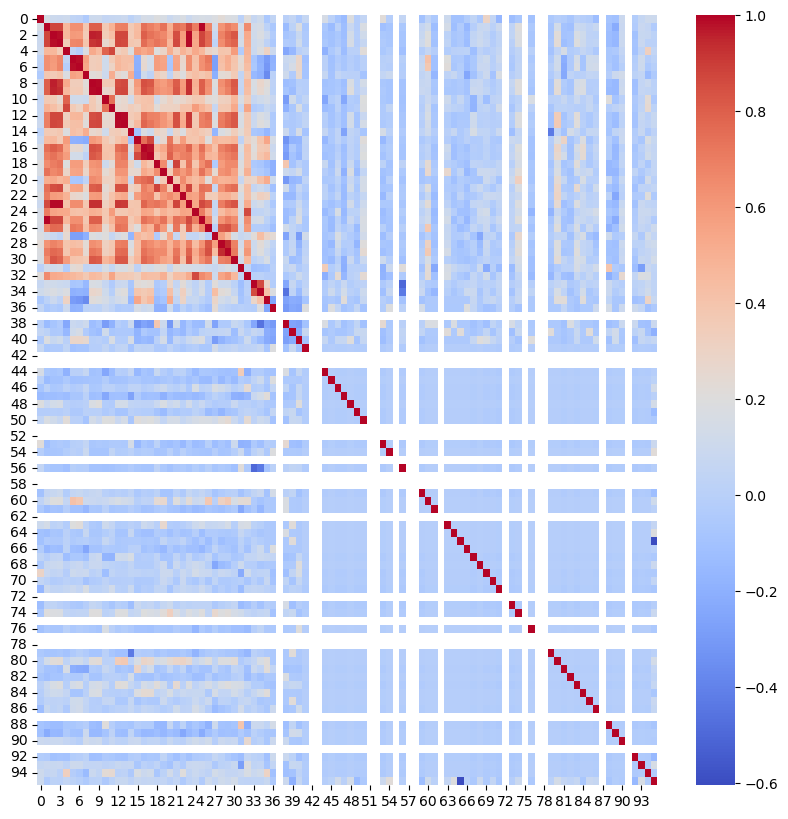

In [152]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation between each column in features_train and final_influence
correlation_matrix = np.corrcoef(features_train.T, final_influence)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [153]:
# find max in correlation_matrix[-1] ignoring nans and 1s
min_corr = np.nanmin(correlation_matrix[-1][correlation_matrix[-1] != 1])
max_corr = np.nanmax(correlation_matrix[-1][correlation_matrix[-1] != 1])
print(min_corr, max_corr)

-0.603976424464312 0.22280773011544752


In [154]:
from scipy.sparse.linalg import eigsh
import scipy

A = (adj - torch.eye(adj.shape[0]).to_sparse()).coalesce()
D_diag = (torch.sparse.sum(A, dim=1)**(-1/2)).coalesce()

# Convert the PyTorch tensor to a Scipy sparse matrix
A_scipy = scipy.sparse.csr_matrix(A.to_dense().numpy())
D_diag_scipy = scipy.sparse.csr_matrix(D_diag.to_dense().numpy())

L = scipy.sparse.eye(A.shape[0]) - (A_scipy.T.multiply(D_diag_scipy)).T.multiply(D_diag_scipy)
eigenvalues, eigenvectors = eigsh(L, k=100, which='LA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)
eigenvalues, eigenvectors = eigsh(L, k=100, which='SA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)

-0.2267900189379481 0.2533563474599704
0.07934856417476827
-0.20976777319196788 0.2906783884536077
0.09163887953137963


### pokecz

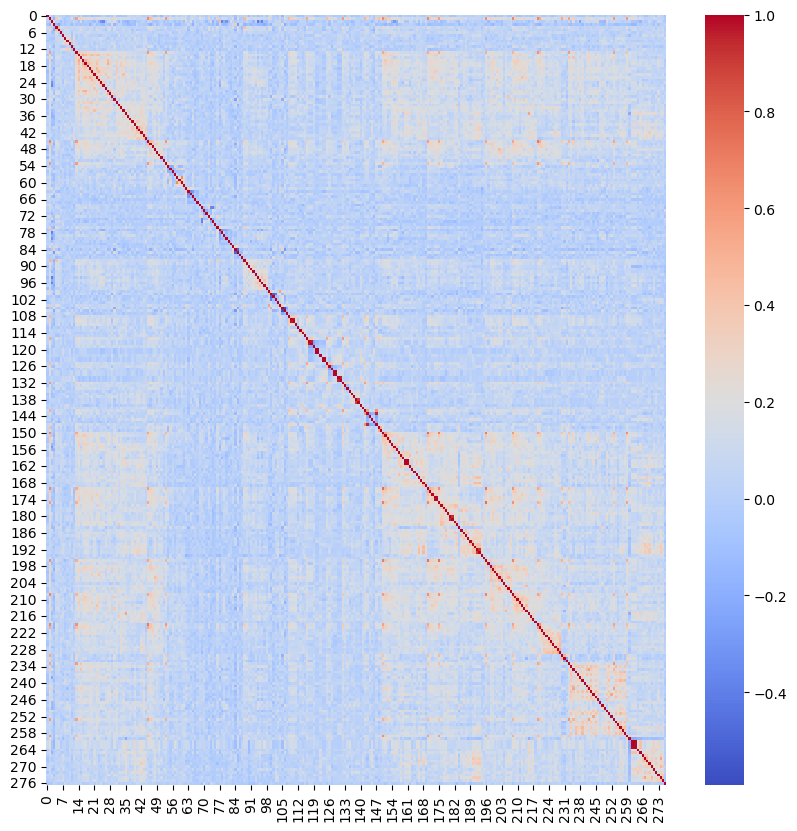

-0.10137867232650576 0.14142369277331468


In [159]:
# load final_influence.npy
final_influence = np.load('test_pdd/pokecz_pdd_train_test.npy')
features_train = features[train_mask]
# convert to numpy
features_train = features_train.cpu().numpy()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation between each column in features_train and final_influence
correlation_matrix = np.corrcoef(features_train.T, final_influence)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
# find max in correlation_matrix[-1] ignoring nans and 1s
min_corr = np.nanmin(correlation_matrix[-1][: -1])
max_corr = np.nanmax(correlation_matrix[-1][: -1])
print(min_corr, max_corr)

In [160]:
from scipy.sparse.linalg import eigsh
import scipy

A = (adj - torch.eye(adj.shape[0]).to_sparse()).coalesce()
D_diag = (torch.sparse.sum(A, dim=1)**(-1/2)).coalesce()

# Convert the PyTorch tensor to a Scipy sparse matrix
A_scipy = scipy.sparse.csr_matrix(A.to_dense().numpy())
D_diag_scipy = scipy.sparse.csr_matrix(D_diag.to_dense().numpy())

L = scipy.sparse.eye(A.shape[0]) - (A_scipy.T.multiply(D_diag_scipy)).T.multiply(D_diag_scipy)
eigenvalues, eigenvectors = eigsh(L, k=1000, which='LA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)
eigenvalues, eigenvectors = eigsh(L, k=1000, which='SA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)

-0.12593770281556532 0.12790945228116257
0.02634720184558649
-0.15441789049576707 0.14547363210687075
0.035169590994540936


### pokecn

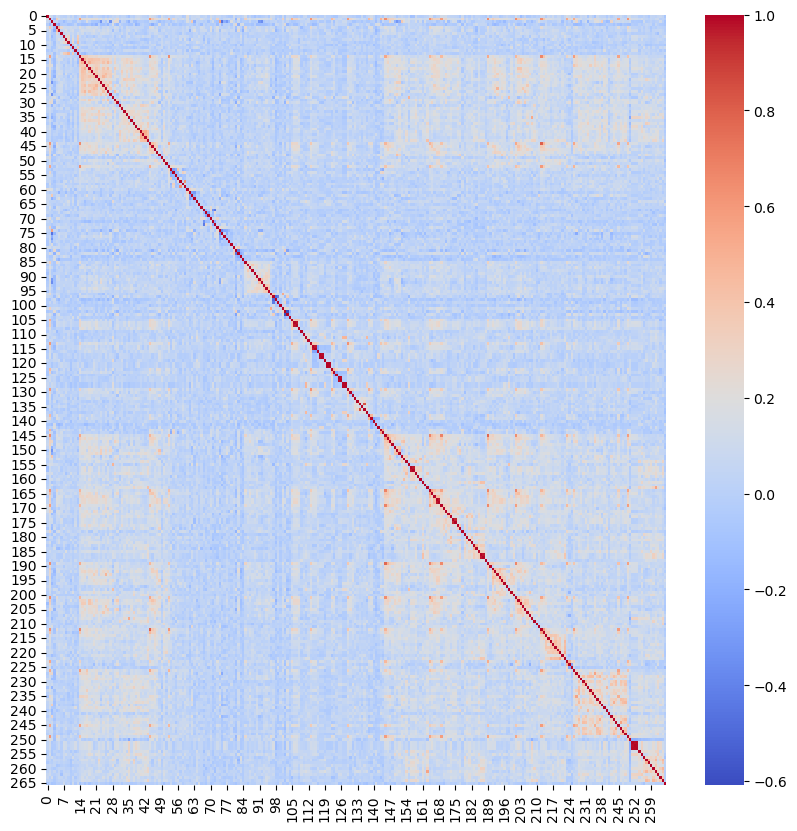

-0.13979008234351561 0.14227805769672314


In [163]:
# load final_influence.npy
final_influence = np.load('test_pdd/pokecn_pdd_train_test.npy')
features_train = features[train_mask]
# convert to numpy
features_train = features_train.cpu().numpy()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation between each column in features_train and final_influence
correlation_matrix = np.corrcoef(features_train.T, final_influence)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
# find max in correlation_matrix[-1] ignoring nans and 1s
min_corr = np.nanmin(correlation_matrix[-1][: -1])
max_corr = np.nanmax(correlation_matrix[-1][: -1])
print(min_corr, max_corr)

In [164]:
from scipy.sparse.linalg import eigsh
import scipy

A = (adj - torch.eye(adj.shape[0]).to_sparse()).coalesce()
D_diag = (torch.sparse.sum(A, dim=1)**(-1/2)).coalesce()

# Convert the PyTorch tensor to a Scipy sparse matrix
A_scipy = scipy.sparse.csr_matrix(A.to_dense().numpy())
D_diag_scipy = scipy.sparse.csr_matrix(D_diag.to_dense().numpy())

L = scipy.sparse.eye(A.shape[0]) - (A_scipy.T.multiply(D_diag_scipy)).T.multiply(D_diag_scipy)
eigenvalues, eigenvectors = eigsh(L, k=1000, which='LA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)
eigenvalues, eigenvectors = eigsh(L, k=1000, which='SA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)

-0.24319109764307464 0.2634200188481491
0.040991456382031305
-0.2633090940905341 0.24320995097274103
0.03838732336409698


### bail

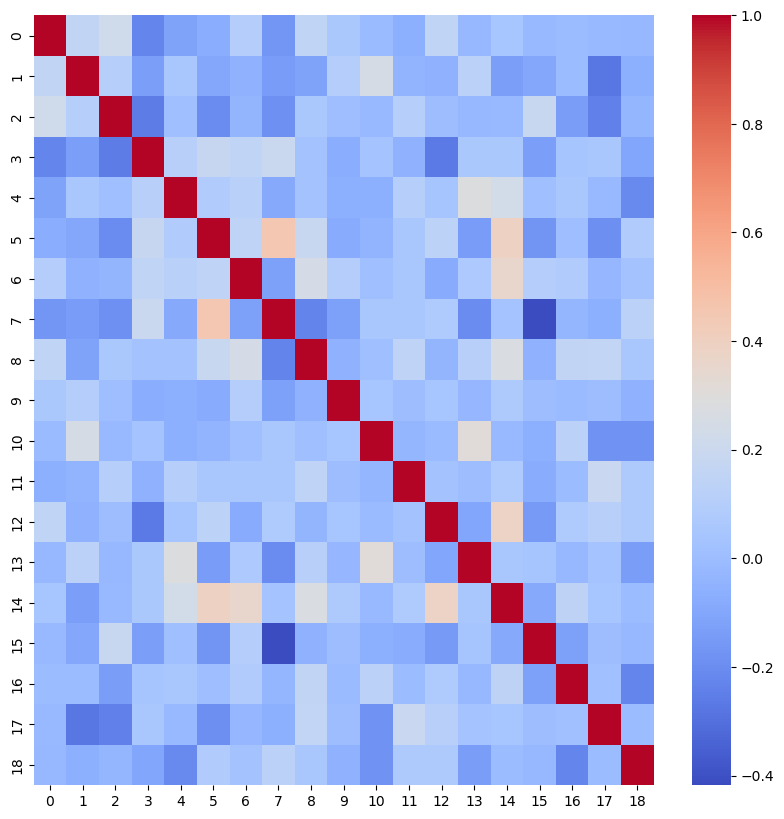

-0.22541787129250168 0.12576910600866867


In [128]:
# load final_influence.npy
final_influence = np.load('test_pdd/bail_pdd_train_test.npy')
features_train = features[train_mask]
# convert to numpy
features_train = features_train.cpu().numpy()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation between each column in features_train and final_influence
correlation_matrix = np.corrcoef(features_train.T, final_influence)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
# find max in correlation_matrix[-1] ignoring nans and 1s
min_corr = np.nanmin(correlation_matrix[-1][: -1])
max_corr = np.nanmax(correlation_matrix[-1][: -1])
print(min_corr, max_corr)

In [100]:
from scipy.sparse.linalg import eigsh
import scipy

A = (adj - torch.eye(adj.shape[0]).to_sparse()).coalesce()
D_diag = (torch.sparse.sum(A, dim=1)**(-1/2)).coalesce()

# Convert the PyTorch tensor to a Scipy sparse matrix
A_scipy = scipy.sparse.csr_matrix(A.to_dense().numpy())
D_diag_scipy = scipy.sparse.csr_matrix(D_diag.to_dense().numpy())

L = scipy.sparse.eye(A.shape[0]) - (A_scipy.T.multiply(D_diag_scipy)).T.multiply(D_diag_scipy)

In [146]:
eigenvalues, eigenvectors = eigsh(L, k=1000, which='LA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)

-0.19350133271835318 0.23444783724607973


In [145]:
eigenvalues, eigenvectors = eigsh(L, k=1000, which='SA')
# Assuming idx_train is a list of indices
correlations = [np.corrcoef(eigenvectors[idx_train][:, i], final_influence)[0, 1] for i in range(eigenvectors.shape[1])]
# find the range of correlations
min_corr = np.nanmin(correlations)
max_corr = np.nanmax(correlations)
print(min_corr, max_corr)
# take absolute value of correlations then take the mean
abs_correlations = np.abs(correlations)
mean_abs_corr = np.mean(abs_correlations)
print(mean_abs_corr)

-0.33404383589782993 0.3031673675607413
